<div class="alert alert-danger">

**Read the `BayesNet Introduction` notebook** before you start working on this problem set! It contains a detailed description of the provided classes *BayesNet* and *Variable* that you will use to solve the following problems.
</div>

# Approximate Inference
## Problem Set 2 

## Probabilistic Models UE

---
In large Bayesian networks, exact inference is impossible. However, we can answer arbitrary queries by generating samples from the target distribution and estimating the probabilities via counting. In the second assignment, you will familiarise yourself with two approximate inference methods for Bayesian networks:
- Rejection Sampling
- Likelihood Weighting

A third one, Gibbs Sampling, will be handled in the third assignment.

## Submission

<div class="alert alert-warning">
    
**Due-Date:** see Moodle
 
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete or add cells.


    
**Submission:** As a ZIP-package via Moodle; the ZIP-package **must have the following structure**:
    
    <student ID, (k + 8 digits), e.g. k01234567>.zip
    +-- Problem 1.ipynb
    |-- Problem 2.ipynb
    |-- Supplementary Materials (optional)
    + 
    
**Questions?** Post them into the Problem Set Forum!
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayesian_network import BayesNet, Variable
from typing import Iterator

# Topological Sort

<div class="alert alert-warning">
Implement the <i>topological sort</i> method for our <i>BayesNet</i> class. (4 points)
</div>


Before we can start implementing the sampling functions required for Rejection Sampling and Likelihood Weighting, we need to ensure that we can iterate through the variables in our Bayesian Network in a topological order. As you may have noticed when going through the `BayesNet Introduction` notebook, this functionality is still missing in the provided `BayesNet` class.

Your task is to implement the method `__iter__` for the `BayesNet` class, which yields all `Variable` objects in a topologically sorted way. This enables us to do the following in Python code:

```
for variable in bayes_net:
    # do something that requires looping over the variables in a topological order,
    # e.g., run forward sampling 
```

You can expect that your function only operates on well-formed Bayesian Networks (=directed acyclic graphs) without handling special cases.

We will simply bind your implemented `__iter__` function from this notebook to the `BayesNet` class using the following assignment in the cell below:

```
BayesNet.__iter__ = __iter__
```

**Hints**: 

- `self.nodes`: is a dictionary containing variable ids as keys and `Variable` objects as values
- `variable.children`: using the `children` attribute of `Variable` objects allows you to access a set of variable ids representing a variable's child nodes
- Remember that python allows you to define **inner** or **nested** functions. For example, if you want to solve topological sort via recursion, you can define an inner function inside the `__iter__` method.

In [2]:
def __iter__(self) -> Iterator[Variable]:
    """
    Iterates over all variables in the Bayesian network in topological ordering, i.e.,
    for an edge from a variable X to a variable Y, X is returned before Y.  
    Since a Bayesian network is a directed acyclic graph, a topological ordering can always be found. 

    :yields: variable after variable according to the network's topology.
    """
    
    # list of topologically sorted variables to be returned
    sorted_variables = list()  
    # all variables in the network encoded as a dictionary (keys: variable ids, values: Variable objects)
    variables = self.nodes  
    

    # My plan: count for each node its deepest depth within the network paths. The deepest depth determines
    # its position within the output list.
    
    # 1. find nodes without parents:
    parent_list = []
    for (id_,value) in self.nodes.items():
        if len(value.parents) == 0:
            parent_list.append(id_)
 
    # 2. go all paths to find the deepest depths:
    # create for each variable a dictionary entry which stores it depth:
    depth_dict = {var:0 for var in variables.keys()}
    
    def inner_func(depth, current_set):
        
        for variable_id in current_set:
            
            depth_dict[variable_id] = depth
            variable_ele = variables[variable_id]
            
            if len(variable_ele.children) > 0:
                
                set_children = variable_ele.children # gives IDs
                
                depth += 1 
                inner_func(depth, set_children) # go one deeper by stepping down to the children
            
    inner_func(depth=0, current_set=parent_list)

    # 3. reformulate the found output to a topologically correctly ordered list:
    sorted_variables_id = dict(sorted(depth_dict.items(), key=lambda item: item[1])).keys()

    sorted_variables = [variables[id_] for id_ in sorted_variables_id]

    for node in sorted_variables:
        yield node
        
    '''
    Depth first search
    Alternative: Kahn's algorithm: look how many parents node has. Go over list for nodes which have 0
    parents and look at the elements' children. 
    '''

# bind the implemented iterator method to the BayesNet
BayesNet.__iter__ = __iter__

In [3]:
# sanity checks
A = np.ones((2,)) / 2
B_AC = np.ones((2,2,2)) / 2
C_A = np.ones((2,2)) / 2
D_BC = np.ones((2,2,2)) / 2

_A_, _B_, _C_, _D_ = 0, 1, 2, 3

bayes_net = BayesNet(
    (A, [_A_]),
    (B_AC, [_B_, _A_, _C_]),
    (C_A, [_C_, _A_]),
    (D_BC, [_D_, _B_, _C_])
)

top_sorted_vars = (_A_, _C_, _B_, _D_)
output = []

for i, variable in enumerate(bayes_net):
    assert isinstance(variable, Variable), f"\nWrong output type!\nExpected: Variable\nGiven: \t {type(variable)}"
    assert variable.id == top_sorted_vars[i], f"\nWrong ordering!\nExpected: \
        {top_sorted_vars}\nGiven: \t ID {variable.id} at position {i+1}"
    output.append(variable)
assert len(output) == len(top_sorted_vars), f"\nWrong number of variables!\nExpected: \
    {len(top_sorted_vars)}\nGiven: \t{len(output)}"
    

# Rejection Sampling


We will implement the rejection sampling algorithm in this notebook and use it to approximate the probabilistic query $P(A \mid D, E)$ for the Bayesian Network given below. In Rejection Sampling, samples from the full joint distribution are drawn, and all samples that do not correspond to the evidence are discarded ('rejected').

To make your solutions testable, we ask you to implement two functions, namely:
- `sample_forward`, and
- `rejection_sampling`.

`sample_forward` returns a set of samples from the full joint distribution $P(\mathcal{X})$.

`rejection_sampling` uses *sample_forward*, throws away all random events with mismatching evidence $\mathbf{E}$, and estimates the distribution of query variable $X$. In other words, it computes an approximation of $P(X \mid \mathbf{E}=e)$. For simplicity, we will only consider probabilistic queries with one query variable $X$.

### Forward Sampling 
<div class="alert alert-warning">
Implement the <i>sample_forward</i> function, which samples from the full joint distribution of a Bayesian network $\mathcal{B}$. (3 points)
</div>

The `sample_forward` function must return one object:
- samples from the Bayesian network $\mathcal{B}$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`


**Hints**: 
- If you have correctly implemented the topological sort, iterating over the *BayesNet* object returns the *Variable* objects in topological ordering. The 1-D probability distribution of variable $X$ given its parents $\mathit{pa}(X)$, $P(X \mid \mathit{pa}(X))$, can be obtained by passing the (possibly incomplete) random event to the variable, i.e., `variable(samples[i])`.
- We will also need a function that samples from a discrete 1-D probability distribution. For this purpose, use the `sample_categorical()` function, which takes a 1-D NumPy array representing a probability distribution and draws a sample from it:

In [4]:
from utils import sample_categorical
help(sample_categorical)

Help on function sample_categorical in module utils:

sample_categorical(dist: numpy.ndarray) -> numpy.int64
    Draws a single sample from a categorical distribution.
    :param dist: NumPy array listing the probability of each outcome.
    :returns: Index of the sampled element.



In [5]:
def sample_forward(bayes_net: BayesNet, sample_size: int) -> np.ndarray:
    '''
    Samples from the full joint distribution.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to draw from the Bayesian network.
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net))
              containing samples from the Bayesian network
    '''
    
    # array holding the samples
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    
    
    for sample_round in range(sample_size):
        
        for i, variable in enumerate(bayes_net):
            
            # sampling gets ignored when variable has no parents:
            distribution = variable(samples[sample_round]) # eg P(A)=[0.2,0.8]
            found_sample = sample_categorical(distribution) # get index of chosen sample of P(A)
            
            samples[sample_round, variable.id] = found_sample
            '''
            Alternative:
            for idx, variable in enumerate(bayes_net):
                var_id = variable.id
                for ii in range(sample_size):
                    pdt = bayes_net[var_id](sample=samples[ii])
                    samples[ii, var_id] = sample_categorical(pdt)
            '''
    return samples

In [6]:
# sanity checks
bayes_net = BayesNet((np.array([0.5, 0.5]), [0]))

samples = sample_forward(bayes_net, 3)

assert type(samples) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(samples)}'
assert samples.shape == (3, 1), f'\nWrong output shape!\nExpected: (3, 1)\nGiven:\t  {samples.shape}'
assert samples.dtype == np.int64, f'\nWrong numpy array data type!\nExpected: np.int64\nGiven:\t  {samples.dtype}'

### Rejection Sampling 
<div class="alert alert-warning">
    Implement the <i>rejection_sampling</i> function, which estimates the probability distribution over the query variable $X$ given evidence  $\mathbf{E}=\mathbf{e}$, i.e. $P(X \mid \mathbf{E}=\mathbf{e})$. Use the <i>sample_forward</i> function implemented in the previous step to draw random events from $P(\mathcal{X})$. (3 points)
</div>

The `rejection_sampling` function must return one object:
-  The 1-D probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable].num_values,)`. If the sample from the FJD does not contain any random events with matching evidence, return a NumPy array with the same shape as $P(X \mid \mathbf{E}=\mathbf{e})$ containing only values `np.nan`, i.e. `np.full(bayes_net[query_variable].num_values, np.nan)`.

**Hints**: 
- Use `np.bincount` to count the number of occurrences of each value. It even supports a minimum number of bins -- check out its  ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html))!
- For simplicity, we will only consider probabilistic queries with one query variable $X$.

In [7]:
def rejection_sampling(bayes_net: BayesNet, query_variable: int, evidence: dict={}, sample_size: int=100) -> np.ndarray:
    '''
    Estimates the distribution of the query variale given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable: Id of the query variable (int).
    :param evidence: A dictionary of evidence variables (keys: int) and their correponding values (values: int).
    :param sample_size: The number of samples to use for the estimation.
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable given evidence, or a NumPy array of the same shape but with all values set to np.nan if no sample with matching evidence is found. 
    '''
    
    # forward sample...
    samples = sample_forward(bayes_net, sample_size)
    
    
    # 1. sampling:
    # done above

    
    # 2. reject:
    for (evidence_id, wanted_evidence_value) in evidence.items():
        samples[np.where(samples[:, evidence_id] != wanted_evidence_value)[0], :] = -1
    
    remaining_samples = samples[np.where(samples[:, 0] != -1)] # shape [some_number_samples, 1]
    remaining_sample_number = remaining_samples.shape[0]
    
    if remaining_sample_number == 0:
        return np.full(bayes_net[query_variable].num_values, np.nan)

    
    # 3. estimate:
    found_query_values = remaining_samples[:, query_variable]
    number_query_appearences = np.bincount(found_query_values, minlength=bayes_net[query_variable].num_values)
    
    distribution = number_query_appearences / remaining_sample_number

    return distribution


In [8]:
# sanity checks
bayes_net = BayesNet((np.array([0.25, 0.25, 0.5]), [0]))

np.random.seed(0)
distribution = rejection_sampling(bayes_net, 0, {0:0}, 3)
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert np.all(np.isnan(distribution)), f'Wrong distribution\nExpected: {np.full(3,np.nan)}\nGot: {distribution}\n'\
                                        'No matching evidence drawn in 3 samples for random seed 0.'

distribution = rejection_sampling(bayes_net, 0, {}, 1000)
assert type(distribution) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(distribution)}'
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert distribution.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {distribution.dtype}'

## Example


Now that we can approximate arbitrary probabilistic queries let us compare an approximation's accuracy to an exact solution.

Consider the following Bayesian Network (all variables are binary):

<img width='30%' src='bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | A, B)</th><th colspan="2">$a_0$<br></th><th colspan="2">$a_1$</th></tr><tr><td>$b_0$</td><td>$b_1$</td><td>$b_0$</td><td>$b_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.01</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.99</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C|D)</th><th>$d_0$<br></th><th>$d_1$</th></tr><tr><td>$c_0$</td><td>0.95</td><td>0.15</td></tr><tr><td>$c_1$</td><td>0.05</td><td>0.85</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.9</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.1</td><td>0.6</td></tr></table>

First, let us store these tables as global NumPy arrays and create the BayesNet object:

In [9]:
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C_D = np.array([[0.95, 0.15], [0.05, 0.85]])
D_AB = np.array([[[0.1, 0.2], [0.01, 0.8]], [[0.9, 0.8], [0.99, 0.2]]])
E_C = np.array([[0.9, 0.4], [0.1, 0.6]])
              
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C_D, [_C_, _D_]),
    (D_AB, [_D_, _A_, _B_]),
    (E_C, [_E_, _C_])
)

### Exact Computation 
<div class="alert alert-warning">
Compute $P(A \mid D, E)$ exactly (up to floating point precision). (1 point)
</div>

Feel free to do this in a very inefficient manner, e.g., by first computing the joint probability distribution and then normalizing by the evidence.

**Hint**: Have a look into the BayesNet Introduction notebook again if you are unsure how to compute the full joint distribution.

In [10]:
A_DE = None

# 1. compute FJDT
fjdt = 1

for variable in bayes_net:
    fjdt = fjdt * variable.pdt

# 2. get P(A, D, E) :
id_A = {bayes_net[_A_].id}
id_D = {bayes_net[_D_].id}
id_E = {bayes_net[_E_].id}
id_all = set([i for i in range(len(bayes_net))])
set_unpart_id = id_all - id_A - id_D - id_E

ADE_fjdt = np.sum(fjdt, axis=tuple(set_unpart_id), keepdims=True)
ADE_fjdt.shape

# 3. get P(D, E):
DE_fjdt = np.sum(ADE_fjdt, axis=tuple(id_A), keepdims=True)

# 4. final result:
A_DE = ADE_fjdt/DE_fjdt
A_DE = A_DE.squeeze() # remove unneeded dimensions

In [11]:
# sanity checks
assert A_DE is not None
assert A_DE.shape == (2, 2, 2)
assert np.all(np.isclose(A_DE.sum(axis=0), 1)), 'Expected well formed distributions with columns summing to 1.'

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with rejection sampling. Different lines represent different value assignments to the evidence variables $D$ and $E$.

**Hint**: The computation of the approximations might take a while...

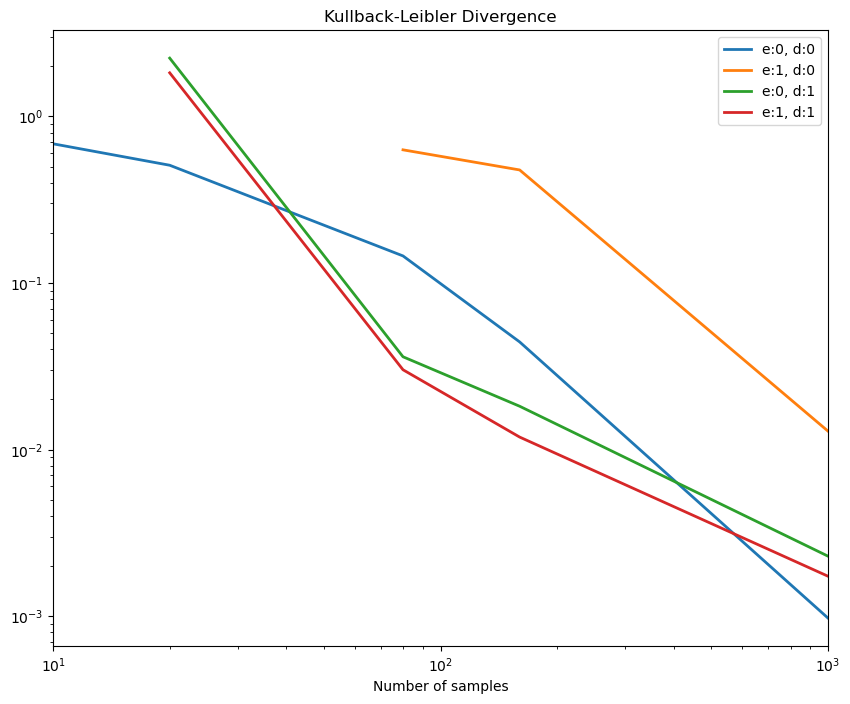

In [12]:
from utils import approx_error

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 80, 160, 1000])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        rejection_sampling,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leibler Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()

<div class="alert alert-warning">
Answer the following question with <b>one short</b> $\LaTeX$ statement! (1 point)
</div>

Given the previous example: What distribution is used to sample a value for variable $D$ in forward sampling? (Just name the distribution, e.g., $P(X \mid Y)$, do not give the exact numbers.)

P(D|A,B)

<div class="alert alert-warning">
Answer the following question in <b>one sentence</b>! (1 point)
</div>

Have a look at the average approximation errors when sampling $10^3$ samples with forward sampling. It can be seen that the approximation error varies for different assignments to the evidence variables $D$ and $E$.

The approximation error of $P(A \mid e=1, d=1)$ is relatively close to the approximation error of $P(A \mid e=0, d=1)$. Can you explain this?

P(e=1,d=1) has a similar probability of happening as P(e=0,d=1) such that they have a similar acceptance rate in the rejection sampling algorithm.

<div class="alert alert-warning">
Store the answer to the following question into the provided result variable! (1 point)
</div>

Assume $d=0$ and $e=0$. On average, how many of the random events sampled from $P(\mathcal{X})$ will be accepted by the rejection sampling algorithm (i.e., not rejected)? Give the fraction of samples accepted, e.g., 0.5, if every 2nd sample contains the correct evidence.

In [13]:
result = 0.46865 # DE_fjdt.squeeze()[0,0] 
# Alternative: inference_by_enumeration(fjdt,_D_,_E_)[0,0]

In [14]:
assert result is not None